In [6]:
import time
import multiprocessing
import qpo_search as q
import numpy as np
import scipy.fft as fft
import matplotlib.pyplot as plt
import os 
import glob
from scipy import stats
from scipy import optimize
from astropy.io import fits
from scipy.optimize import curve_fit
from astropy.io import ascii
from astropy.table import Table
import csv
import math
import stingray
import lightcurve
from stingray import Lightcurve
#from stingray import Powerspqpoectrum
from stingray import AveragedPowerspectrum
from stingray import Crossspectrum
from stingray.exceptions import StingrayError
from stingray import AveragedCrossspectrum
from more_itertools import locate
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import scipy
from scipy import stats
from scipy import optimize
from scipy.stats import f
import scipy.integrate as integrate
import scipy.special as special
from scipy.special import erfinv, erf
#from sklearn import preprocessing
from pynverse import inversefunc
import pynverse
import warnings
warnings.filterwarnings('ignore')
from concurrent.futures import ThreadPoolExecutor
from joblib import Parallel, delayed
from multiprocessing import Process
import threading
import multiprocessing as mp
from multiprocessing import Pool
from functools import partial

import numpy as np
import scipy.fft as fft
import matplotlib.pyplot as plt
import os 
import glob
import pandas as pd
from scipy import stats
from scipy import optimize
from astropy.io import fits
from scipy.optimize import curve_fit
from astropy.io import ascii
from astropy.table import Table
import csv
import math
import stingray
import lightcurve
from stingray import Lightcurve
from stingray import Powerspectrum
from stingray import AveragedPowerspectrum
from stingray import Crossspectrum
from stingray.exceptions import StingrayError
from stingray import AveragedCrossspectrum
from more_itertools import locate
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import scipy.integrate as spi
import pynverse
from pynverse import inversefunc
import functools
from functools import partial
import warnings
from multiprocessing import Pool
warnings.filterwarnings('ignore')

# 1000 Runs logistics

### Currently I only have the calculation of the new modulation angles parallelised which outputs (cpu_num) files to a given directory. For 1000 runs we cant have 1000*(cpu_num) modulation angle files due to memory issues so we need to internalise the mod angle calculation code into the G calculation code so we can disgard this data after it has been used. This could be done by calling the parallelised function in the G calculaiton function (which itself calls the cdf function).



### Im not sure if its worth parallelising the G calc code itself since the mod function code will be taking up the cpu space with its own calculation.

### I will also need to create some sort of running sum to stack each simulation run rather than again saving 1000 rounds of G results.

### For both the mod angles and the G results, I could have lists that are reset to zero when the calculation is zero.


### To keep track of the modulation angle calc over the cpus i could have a run counter incorporated into the name and loop over that

### Future to do: turn pandas df into list comprehensions

### I need the ith+1  G run to be calculating the ith mod angle run so that the G code isnt waiting for the next round of mod angles. Ie i want the G code to be running as the new set of mod angles is being calculated 


# Adding spurious polarisation

- For each event we need to work out from the maps what the spurious q and u are qsp and usp 
-find mu for each event (already do)
- then add them to the stokes of the events q0 and u0

q=q0+qsp where q0=mu*PDcos(2PA)
u=u0+usp where u0=mu*PDsin(2PA)

mu*p =sqrt(q**2+u**2)
psi=atan2(u,q)

-in random variable code select mod angle phi as func of mu,p,psi instead of mu,PD,pa  OR  psi(1,mu*p,psi)



SP has 6 maps based on energy and each are an Y and X NOT NEEDED

-what detector (ie what fits file) not neeede
-extrapolate E NOT NEEDED

#creating simualted q,u BY ADDING SPUR



FINAL DAY 1ST DEC



# NEW PARALLELISATION PLAN-6 OF THE SAME SHIT RUNNIN AT THE SAME TIME DAWG

In [3]:
def new_null(source_name,file12,file3,mue_file,GTI_file,run_num_tot,cpu_num,Pmin,Pmax,bin_length,seg_length,fmin,fmax,modmin,modmax,mod_bin_number,p,psi):
    print('started')
    #first do the things we only need to do once
    with fits.open(str(file12)) as hdu:
            data_12=hdu[1].data  #reading in DU1+DU2
    
    with fits.open(str(file3)) as hdu2:
            data_header=hdu2[1].header #reading in header 
            data_3=hdu2[1].data #reading in DU3
            #print(data_3)
            #energy cut
            index_energy=list(locate(data_12.field('PI'), lambda x: Pmin < x < Pmax))  
            data_12=data_12[index_energy]
            index_energy_3=list(locate(data_3.field('PI'), lambda x: Pmin < x < Pmax))
            data_3=data_3[index_energy_3]

            #quality factor cut
            index_qual_12=list(locate(data_12.field('QUAL'), lambda x: x==1)) 
            data_12=data_12[index_qual_12]
            index_qual_3=list(locate(data_3.field('QUAL'), lambda x: x==1))  
            data_3=data_3[index_qual_3]
            
            TSTART=data_header['TSTART']
            TSTOP=data_header['TSTOP']
            curve_duration=TSTOP-TSTART                  

            TIME=data_12.field('TIME')
            TIME_3=data_3.field('TIME')
            print(TIME_3)
           
            GTI=list(np.loadtxt(str(GTI_file)))
            #Lightcurves for norm
            lightcurve_12=Lightcurve.make_lightcurve(TIME,dt=bin_length,tstart=TSTART,gti=GTI)
            lightcurve_12.apply_gtis()
            print('lc 12')
            #print(len(lightcurve_12.counts))
            plt.figure()
            plt.plot(lightcurve_12.time,lightcurve_12.counts)
            plt.show()
          
            
            lc_ref=Lightcurve.make_lightcurve(TIME_3,dt=bin_length,tstart=TSTART,gti=GTI)
            lc_ref.apply_gtis()
            print('lc ref')
            #print(len(lc_ref.counts))
            plt.figure()
            plt.plot(lc_ref.time,lc_ref.counts)
            plt.show()
          
            #Cross spec for norm ie over all mod angle bins

            avg_cs = AveragedCrossspectrum.from_lightcurve(lightcurve_12,lc_ref,seg_length,norm='frac')
            print('avg cs')
            
            
            norm_power_real=avg_cs.power.real  #cross spec properties
            norm_power_im=avg_cs.power.imag
            norm_freq=avg_cs.freq
            
          
            #real power of all mod cross spec (for norm constant and 2019 errorbars)
            norm_d = {'real_power': np.array(avg_cs.power.real), 'all_fourier_freq': np.array(avg_cs.freq)} #total pwr and freq in dataset
            df_norm = pd.DataFrame(data=norm_d)
            selected_rows_norm = df_norm[(df_norm['all_fourier_freq'] >= fmin) & (df_norm['all_fourier_freq'] <= fmax)] #selecting freq range
            av_power_norm_real=selected_rows_norm['real_power'].mean() #calculating mean pwr
            
            #av_power_norm_array.append(av_power_norm_real)
          
            #calculating normalisation constant
            
            norm_factor=(np.sqrt((fmax-fmin))/np.sqrt(av_power_norm_real))
            #norm_factor_array.append(norm_factor) 
            #np.savetxt('Results/norm_cs_'+str(source_name)+'_freqs_'+str(fmin)+'_'+str(fmax)+'_'+str(bin_length)+'_'+str(seg_length)+'.txt',norm_factor_array)

            #making a list of mod angle bins to select over
            mod_minimum=np.radians(modmin)
            mod_maximum=np.radians(modmax)
            aspace=np.linspace(mod_minimum,mod_maximum,mod_bin_number+1)
            mod_angle_list=[(aspace[i-1],aspace[i]) for i in range(len(aspace))]  #making a list of mod angle bins to select over
            mod_angle_list.pop(0) #removing the dodger first one
            
            mue=np.loadtxt(mue_file)[:,2]
            modulation_factor_12=np.array([mue[int(i)] for i in data_12.field('PI')])
            print(modulation_factor_12)
            modulation_factor_3=np.array([mue[int(i)] for i in data_3.field('PI')])
        
            #for mod_fac in modulation_factor_12:
            #    print(mod_fac)

            run_num=0
            

            mod_G_stacked=[]
            arg_G_stacked=[]
            d_mod_G_stacked=[]
            d_arg_G_stacked=[]
    
           
    
            while run_num<2:
                print('in while loop')
                run_num+=1

                mod_angle_array_12=[]
                mod_angle_array_3=[]
                
 #               for mod_fac in modulation_factor_12:
 #                   #print(mod_fac)
 #                   
#                    cdf=(lambda phi: phi - mod_min + 0.5*mu*p * ( np.sin( 2*phi - 2*psi ) - np.sin( 2*mod_min - 2*psi ) ))
 #                   cdf_min_12=cdf_12(np.radians(-90))
 #                   cdf_max_12=cdf_12(np.radians(90))
 #                   random_12=np.random.uniform(cdf_min_12,cdf_max_12)
 #                   mod_angle_array_12.append(inversefunc(cdf_12, y_values=random_12))
                    #print(mod_angle_array_12)

                print('mod angles calculated')




               # for mod_fac in modulation_factor_3:
               #     cdf_3=(lambda i: (1/np.pi) * (i +  (mu*p*0.5) * (np.sin((2*i)-(2*psi)) + np.sin(2*psi))))
               #     cdf_min_3=cdf(np.radians(0))
               #     cdf_max_3=cdf(np.radians(180))
               #     random_3=np.random.uniform(cdf_min,cdf_max)
               #     mod_angle_array_3.append(inversefunc(cdf_3, y_values=random_3))


                av_power_G_array=[]
                m_array=[]
                av_power_array_mod_ps_12=[]
                av_power_array_mod_ps_3=[]
                av_power_array_real=[]
                av_power_array_im=[]
                mod_angle_array_12=data_12.field('PHI')

                for i in mod_angle_list:
                    mod_min=i[0]
                    print(np.degrees(mod_min))
                    mod_max=i[1]

                    print(np.degrees(mod_max))

                    index_mod_angle=[mod_min<=k<=mod_max for k in mod_angle_array_12] #define the index over mod angle
                    data_bin_12=data_12[index_mod_angle] #selecting/indexing the photons that meet the criteria of this mod angle range
                
                    print('len data bin 12',len(data_bin_12))
                    TIME_12=data_bin_12['TIME']
                    print(TIME_12)

                    #making subject lightcurve
                    lc_12=Lightcurve.make_lightcurve(TIME_12,dt=bin_length,tstart=TSTART,gti=GTI)
                    lc_12.apply_gtis()
                    
                    print('lc sub')
                    
                    plt.figure()
                    plt.plot(lc_12.time,lc_12.counts)
                    plt.show()
                    
                    
                    
                    
                    

In [3]:
                    #making powerspectrum for errorbars
                        #power spectrum used for frac rms errorbars
                    ps_12=Powerspectrum.from_lightcurve(lc_12,seg_length,norm='frac')
                    ps_3=Powerspectrum.from_lightcurve(lc_ref,seg_length,norm='frac')

                    #making averagd cross spectrum
                    cs = AveragedCrossspectrum.from_lightcurve(lc_12,lc_ref,seg_length,norm='frac') #making averagd cross spec
                    mod_G=np.sqrt((cs.power.real)**2+(cs.power.imag**2))
                    m=cs.m



                    fourier_f=cs.freq
                    real_power=cs.power.real   #real and im power of G
                    im_power=cs.power.imag

                   #averaging the modulus of G to use in drms

                    #d_G_ = {'G': np.array(mod_G), 'fourier_freq': np.array(cs.freq)}
                    #df_G = pd.DataFrame(data=d_G_)
                    #selected_rows_G = df_G[(df_G['fourier_freq'] >= fmin) & (df_G['fourier_freq'] <= fmax)]
                    
                    #print(selected_rows_G[:1000])
                    
                    freq_index=list(locate(np.array(cs.freq), lambda x: fmin <= x <= fmax))
        
                    mod_G_selected=mod_G[freq_index]
                    #print(mod_G_selected[:1000])
                    
                
                    av_power_G=mod_G_selected.mean()
                    #print('modulus of G mean: {}'.format(av_power_G))
                    av_power_G_array.append(av_power_G)
                    #np.savetxt('Results/av_G_mod'+str(source_name)+'_'+str(mod_bin_number)+'_bins_freqs_'+str(fmin)+'_'+str(fmax)+'_'+str(bin_length)+'_'+str(seg_length)+'.txt',av_power_G_array)

                    


                   #averaging the power spectrum over fourier freq for drms errorbars

                    mod_ps_12=ps_12.power.real #this is because the poewr spectrum is real by definition!
                    mod_ps_3=ps_3.power.real


                    #d_mod_ps_12 = {'mod_power_ps_12': np.array(mod_ps_12), 'fourier_freq': np.array(ps_12.freq)}
                    #df_mod_ps_12 = pd.DataFrame(data=d_mod_ps_12)
                    #selected_rows_mod_ps_12 = df_mod_ps_12[(df_mod_ps_12['fourier_freq'] >= fmin) & (df_mod_ps_12['fourier_freq'] <= fmax)]
                    selected_rows_mod_ps_12=mod_ps_12[freq_index]
                    av_power_mod_ps_12=selected_rows_mod_ps_12.mean()
                    av_power_array_mod_ps_12.append(av_power_mod_ps_12)


                    #d_mod_ps_3 = {'mod_power_ps_3': np.array(mod_ps_3), 'fourier_freq': np.array(ps_3.freq)}
                    #df_mod_ps_3 = pd.DataFrame(data=d_mod_ps_3)
                    #selected_rows_mod_ps_3 = df_mod_ps_3[(df_mod_ps_3['fourier_freq'] >= fmin) & (df_mod_ps_3['fourier_freq'] <= fmax)]
                    selected_rows_mod_ps_3=mod_ps_3[freq_index]
                    av_power_mod_ps_3=selected_rows_mod_ps_3.mean()
                    av_power_array_mod_ps_3.append(av_power_mod_ps_3)



                    #Average real power over frequency range
                    #d_real = {'real_power': np.array(real_power), 'fourier_freq': np.array(cs.freq),'dPco':np.array(dPco)}
                    #df_real = pd.DataFrame(data=d_real)
                    #selected_rows_real = df_real[(df_real['fourier_freq'] >= fmin) & (df_real['fourier_freq'] <= fmax)]
                    selected_rows_real=real_power[freq_index]
                    av_power_real=selected_rows_real.mean()
                    av_power_array_real.append(av_power_real)
                    #np.savetxt('Results/G_av_real_'+str(source_name)+'_'+str(mod_bin_number)+'_bins_freqs_'+str(fmin)+'_'+str(fmax)+'_'+str(bin_length)+'_'+str(seg_length)+'.txt',av_power_array_real)


                    #Average imaginary power over frequency
                    #d_im = {'im_power': np.array(im_power), 'fourier_freq': np.array(cs.freq),'dPcoim': np.array(dPcoim)}
                    #df_im = pd.DataFrame(data=d_im)
                    #selected_rows_im = df_im[(df_im['fourier_freq'] >= fmin) & (df_im['fourier_freq'] <= fmax)]
                    selected_rows_im=im_power[freq_index]
                    av_power_im=selected_rows_im.mean()
                    av_power_array_im.append(av_power_im)
                    #np.savetxt('Results/G_av_im_'+str(source_name)+'_'+str(mod_bin_number)+'_bins_freqs_'+str(fmin)+'_'+str(fmax)+'_'+str(bin_length)+'_'+str(seg_length)+'.txt',av_power_array_im)


                    #everything i want from a single run    
                    mod_G_av=np.sqrt(np.array(av_power_array_real)**2+np.array(av_power_array_im)**2)
                    
                    
                    #complex_G=[av_power_array_real+1j*av_power_array_im for i in range(len(av_power_array_real))]
                    complex_G=[complex(a,b) for a, b in zip(av_power_array_real, av_power_array_im)] 

                    print(complex_G)
                    
                    arg_G_av=np.vectorize(np.angle(complex_G))
                    d_mod_G=np.sqrt((1/(2*(len(selected_rows_real)*cs.m)))*((av_power_mod_ps_12*av_power_mod_ps_3)-((av_power_mod_ps_3/(av_power_norm_real))*(av_power_G**2))))
                    d_arg_G_av=d_mod_G/av_power_G
                    print(mod_G_av)
                    run_num=+1




            mod_G_stacked+=mod_G_av/m
            #run_num=+1

            return mod_G_av
        #arg_G_stacked=[]
        #d_mod_G_stacked=[]
        #d_arg_G_stacked=[]


        #g_stacked=((complex_power*m_1)+(complex_power_2*m_2))/(m_1+m_2)
        #g_real_stacked=np.real(g_stacked)
        #g_im_stacked=np.imag(g_stacked)

        #norm_power_stacked=((sqrt_norm_power_1**2*m_1_norm)+(sqrt_norm_power_2**2*m_2_norm))/(m_1+m_2)
        #norm_factor_stacked=(fmax-fmin)/np.sqrt(norm_power_stacked)

        #frac_norm=(np.sqrt(g_real_stacked**2+g_im_stacked**2))*norm_factor_stacked

        #phase=(atan2_vec(g_im_stacked,g_real_stacked))


        #dG=np.sqrt(((m_1*dG_1)**2+(m_2*dG_2)**2))/(m_1+m_2)
        #d_phi=dG/np.sqrt(g_real_stacked**2+g_im_stacked**2)













            

In [6]:
np.sqrt(6)/6

0.40824829046386296

In [103]:
(source_name,file12,file3,mue_file,GTI_file,run_num_tot,cpu_num,Pmin,Pmax,bin_length,seg_length,fmin,fmax,modmin,modmax,mod_bin_number,p,psi):

In [4]:
#the main problem we want to parallelise is the running of this code 1000 times.
#Therefore the subtasks of this parallelisation is running the code 1000/cpu_num times



def run_new_null(source_name,file12,file3,mue_file,GTI_file,run_num_tot,cpu_num,Pmin,Pmax,bin_length,seg_length,fmin,fmax,modmin,modmax,mod_bin_number,p,psi):
    #new_null_partial=partial(new_null,file12=file12,file3=file3,p=p,psi=psi,source_name=source_name,cpu_num=cpu_num,run_num_tot=run_num_tot)
    #counter=0
    #a=source_name,file12,file3,mue_file,Pmin,Pmax,modmin,modmax,p,psi,cpu_num,run_num_tot
    #print(iterable)
    #print(cpu)
    with Pool(processes=cpu_num) as pool:
              #result = pool.map(new_null_partial,)
              result=pool.apply(new_null,(source_name,file12,file3,mue_file,GTI_file,run_num_tot,cpu_num,Pmin,Pmax,bin_length,seg_length,fmin,fmax,modmin,modmax,mod_bin_number,p,psi))
    
              print(result)

started
[1.69402263e+08 1.69402263e+08 1.69402263e+08 ... 1.69926652e+08
 1.69926652e+08 1.69926652e+08]
lc 12


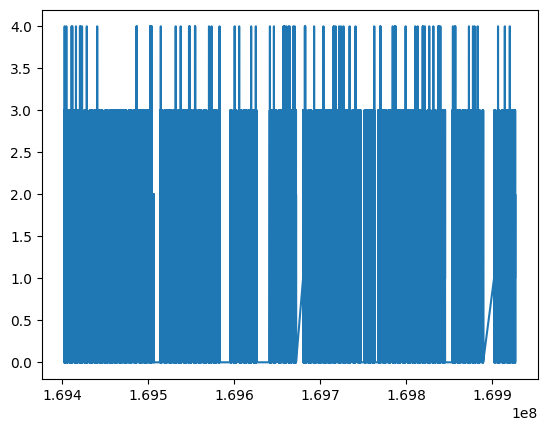

lc ref


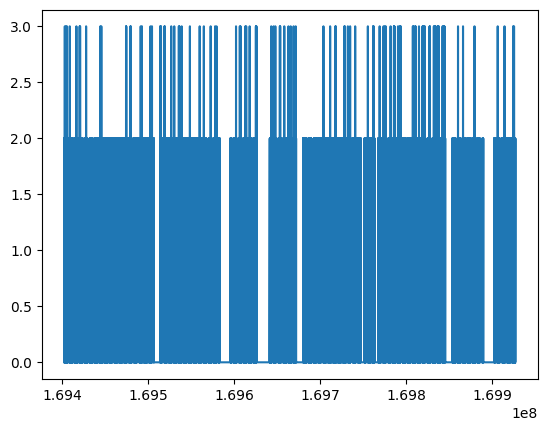

avg cs
[0.36566678 0.30120802 0.49993181 ... 0.18614535 0.17793779 0.25435677]
in while loop
mod angles calculated
-90.0
-81.0
len data bin 12 318833
[1.69402265e+08 1.69402265e+08 1.69402270e+08 ... 1.69926648e+08
 1.69926648e+08 1.69926652e+08]
lc sub


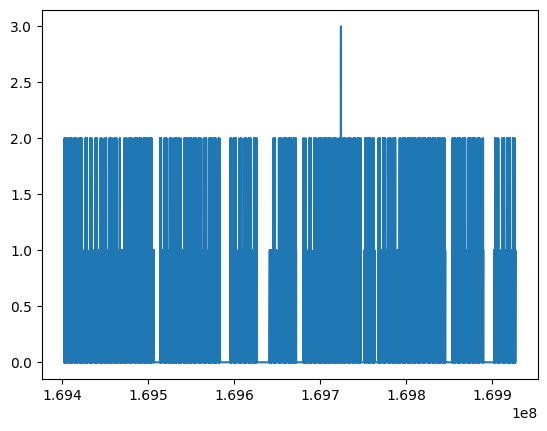

-81.0
-72.0
len data bin 12 322111
[1.69402263e+08 1.69402264e+08 1.69402265e+08 ... 1.69926648e+08
 1.69926650e+08 1.69926651e+08]


KeyboardInterrupt: 

In [5]:
#source_name,file12,file3,mue_file,GTI_file,run_num_tot,cpu_num,Pmin,Pmax,bin_length,seg_length,fmin,fmax,modmin,modmax,mod_bin_number,p,psi):


run_new_null('cygx1_may_newnull','/home/c2032014/PhD/CYGX1_MAY/det12_src.fits','/home/c2032014/PhD/CYGX1_MAY/ixpe01002901_det3_evt1pt5_v01_src.fits','/home/c2032014/PhD/muE.txt','/home/c2032014/PhD/CYGX1_MAY/cygx1_may1_gti.txt',2,1,51,200,1/256,2048,1,2,-90,90,20,4,-18)

In [4]:
import platform

# Get the CPU information
cpu_info = platform.processor()

# Use the CPU information to construct the file name
file_name = f"result_{cpu_info}.txt"

# Save your data to the file with the constructed name
with open(file_name, 'w') as file:
    file.write("Your data goes here.")

print(f"File saved as: {file_name}")


File saved as: result_x86_64.txt


In [11]:
import multiprocessing
import time

def save_file(process_number):
    # Simulate some computation or file processing
    time.sleep(1)
    
    # Get the current process number
    current_process_number = multiprocessing.current_process().name
    print(current_process_number)
    
    # Construct the file name with the process number
    file_name = f"output_beep_{current_process_number}.txt"
    
    # Save data to the file
    with open(file_name, 'w') as file:
        file.write(f"Data processed by process {current_process_number}")

if __name__ == "__main__":
    # Specify the number of processes
    num_processes = 6
    
    # Create a pool of processes
    with multiprocessing.Pool(processes=num_processes) as pool:
        # Use the pool to apply the function to each process
        pool.map(save_file, range(num_processes))


ForkPoolWorker-27ForkPoolWorker-28ForkPoolWorker-26ForkPoolWorker-29ForkPoolWorker-30
ForkPoolWorker-25






In [13]:
import multiprocessing
import time
import re

def save_file(process_number):
    # Simulate some computation or file processing
    time.sleep(1)
    
    # Get the current process number
    current_process_name = multiprocessing.current_process().name
    
    # Extract the numeric part from the process name
    match = re.search(r'\d+', current_process_name)
    current_process_number = int(match.group()) if match else None
    
    # Construct the file name with the desired process number
    file_name = f"output_{current_process_number}.txt" if current_process_number is not None else "output_unknown.txt"
    
    # Save data to the file
    with open(file_name, 'w') as file:
        file.write(f"Data processed by process {current_process_number}")

if __name__ == "__main__":
    # Specify the number of processes
    num_processes = 6
    
    # Create a pool of processes
    with multiprocessing.Pool(processes=num_processes) as pool:
        # Use the pool to apply the function to each process
        pool.map(save_file, range(num_processes))


In [14]:
import multiprocessing
import time

def save_file(process_number):
    # Simulate some computation or file processing
    time.sleep(1)
    
    # Use the process number directly
    current_process_number = process_number
    
    # Construct the file name with the desired process number
    file_name = f"output_{current_process_number}.txt"
    
    # Save data to the file
    with open(file_name, 'w') as file:
        file.write(f"Data processed by process {current_process_number}")

if __name__ == "__main__":
    # Specify the number of processes
    num_processes = 6
    
    # Create a pool of processes
    with multiprocessing.Pool(processes=num_processes) as pool:
        # Use the pool to apply the function to each process
        pool.map(save_file, range(num_processes))


In [15]:
import multiprocessing
import time

def save_file(process_number):
    # Simulate some computation or file processing
    time.sleep(1)
    
    # Use the process number directly
    current_process_number = process_number
    
    # Construct the file name with the desired process number
    file_name = f"output_{current_process_number}.txt"
    
    # Save data to the file
    with open(file_name, 'w') as file:
        file.write(f"Data processed by process {current_process_number}")

if __name__ == "__main__":
    # Specify the number of processes
    num_processes = 6
    
    # Create a pool of processes
    with multiprocessing.Pool(processes=num_processes) as pool:
        # Use pool.apply to apply the function to each process
        for process_number in range(num_processes):
            pool.apply(save_file, (process_number,))


In [21]:
110/30


3.6666666666666665

# running a basic parallelisation code

In [34]:


def basic_func(iterable,x):
    d=x**2
    print('core {} d {}'.format(iterable,d))



def run_basic_par(x,cpu_num):
    basic_func_partial=partial(basic_func,x=x)
    #counter=0
    #a=source_name,file12,file3,mue_file,Pmin,Pmax,modmin,modmax,p,psi,cpu_num,run_num_tot
    #print(iterable)
    #print(cpu)
    iterable=np.array(range(cpu_num))
    with Pool(processes=cpu_num) as pool:
              #result = pool.map(new_null_partial,)
              result=pool.map(basic_func_partial,iterable)



In [38]:
run_basic_par(2,4)

core 2 d 4core 1 d 4core 0 d 4core 3 d 4





## Attempting to use manager in multiprocessing to read in the fits files once and use the results in shared memory between cpus as to not overload the RAM

In [39]:
from multiprocessing import Process, Manager

def f(d, l):
    d[1] = '1'
    d['2'] = 2
    d[0.25] = None  #function with the data we want to share over cores maybe?? creating a dictionary here
    l.reverse()  

if __name__ == '__main__':
    with Manager() as manager:
        d = manager.dict()
        l = manager.list(range(10))

        p = Process(target=f, args=(d, l))
        p.start()
        p.join()

        print(d)
        print(l)

        
        


{1: '1', '2': 2, 0.25: None}
[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


Using a manager involves four steps, they are:

    Create the manager instance.
    Start the manager.
    Create one or more hosted objects to share.
    Shutdown the manager.


In [41]:
with Manager() as manager:
    shared_list = manager.list()

ProcessError: Already started server

In [2]:
def run_new_null_manager(source_name,file12,file3,mue_file,GTI_file,run_num_tot,cpu_num,Pmin,Pmax,bin_length,seg_length,fmin,fmax,modmin,modmax,mod_bin_number,p,psi):
    
     with fits.open(str(file12)) as hdu:
            data_12=hdu[1].data  #reading in DU1+DU2
    
     with fits.open(str(file3)) as hdu2:
            data_header=hdu2[1].header #reading in header 
            data_3=hdu2[1].data #reading in DU3
            #print(data_3)
            #energy cut
            index_energy=list(locate(data_12.field('PI'), lambda x: Pmin < x < Pmax))  
            data_12=data_12[index_energy]
            index_energy_3=list(locate(data_3.field('PI'), lambda x: Pmin < x < Pmax))
            data_3=data_3[index_energy_3]

            #quality factor cut
            index_qual_12=list(locate(data_12.field('QUAL'), lambda x: x==1)) 
            data_12=data_12[index_qual_12]
            index_qual_3=list(locate(data_3.field('QUAL'), lambda x: x==1))  
            data_3=data_3[index_qual_3]

            TSTART=data_header['TSTART']
            TSTOP=data_header['TSTOP']
            curve_duration=TSTOP-TSTART

            TIME=data_12.field('TIME')
            TIME_3=data_3.field('TIME')
            #print(TIME_3)

            GTI=list(np.loadtxt(str(GTI_file)))
            #Lightcurves for norm
            lightcurve_12=Lightcurve.make_lightcurve(TIME,dt=bin_length,tstart=TSTART,gti=GTI)
            lightcurve_12.apply_gtis()
            #print('lc 12')
            #print(len(lightcurve_12.counts))
            #plt.figure()
            #plt.plot(lightcurve_12.time,lightcurve_12.counts)
            #plt.show()


            lc_ref=Lightcurve.make_lightcurve(TIME_3,dt=bin_length,tstart=TSTART,gti=GTI)
            lc_ref.apply_gtis()
            #print('lc ref')
            #print(len(lc_ref.counts))
            #plt.figure()
            #plt.plot(lc_ref.time,lc_ref.counts)
            #plt.show()

            #Cross spec for norm ie over all mod angle bins

            avg_cs = AveragedCrossspectrum.from_lightcurve(lightcurve_12,lc_ref,seg_length,norm='frac')
            #print('avg cs')


            norm_power_real=avg_cs.power.real  #cross spec properties
            norm_power_im=avg_cs.power.imag
            norm_freq=avg_cs.freq


            #real power of all mod cross spec (for norm constant and 2019 errorbars)
            norm_d = {'real_power': np.array(avg_cs.power.real), 'all_fourier_freq': np.array(avg_cs.freq)} #total pwr and freq in dataset
            df_norm = pd.DataFrame(data=norm_d)
            selected_rows_norm = df_norm[(df_norm['all_fourier_freq'] >= fmin) & (df_norm['all_fourier_freq'] <= fmax)] #selecting freq range
            av_power_norm_real=selected_rows_norm['real_power'].mean() #calculating mean pwr

            #av_power_norm_array.append(av_power_norm_real)

            #calculating normalisation constant

            norm_factor=(np.sqrt((fmax-fmin))/np.sqrt(av_power_norm_real))
            norm_factor_array=[]
            norm_factor_array.append(norm_factor) 
            np.savetxt('Results/newnull_norm_cs_'+str(source_name)+'_freqs_'+str(fmin)+'_'+str(fmax)+'_'+str(bin_length)+'_'+str(seg_length)+'.txt',norm_factor_array)

            
            #making a list of mod angle bins to select over
            mod_minimum=np.radians(modmin)
            mod_maximum=np.radians(modmax)
            aspace=np.linspace(mod_minimum,mod_maximum,mod_bin_number+1)
            mod_angle_list=[(aspace[i-1],aspace[i]) for i in range(len(aspace))]  #making a list of mod angle bins to select over
            mod_angle_list.pop(0) #removing the dodger first one

            mue=np.loadtxt(mue_file)[:,2]
            modulation_factor_12=np.array([mue[int(i)] for i in data_12.field('PI')])
            #print(modulation_factor_12)
            modulation_factor_3=np.array([mue[int(i)] for i in data_3.field('PI')])
            
            
            
            #what i need to transfer over to the parallelised 
            
            #mod_angle_list
            #modulation_factor_12
            #modulation_factor_3
            #GTI
            #TIME
            #TIME_3
            #TSTART
            

            
            
            manager = multiprocessing.Manager()
    
    
            mod_angle_list = manager.list(mod_angle_list)
            modulation_factor_12 = manager.list(modulation_factor_12)
            modulation_factor_3 = manager.list(modulation_factor_3)
            GTI=manager.list(GTI)
            TIME=manager.list(TIME)
            TIME_3=manager.list(TIME_3)
            TSTART=manager.list(TSTART)
            
            
            
            
            
            
            new_null_manager_partial=partial(new_null_manager,mod_angle_list=mod_angle_list,modulation_factor_12=modualtion_factor_12,modulation_factor_3=modulation_factor_3,GTI=GTI,TIME=TIME,TIME_3=TIME_3,TSTART=TSTART,source_name=source_name,run_num_tot=run_num_tot,cpu_num=cpu_num,Pmin=Pmin,Pmax=Pmax,bin_length=bin_length,seg_length=seg_length,fmin=fmin,fmax=fmax,modmin=modmin,modmax=modmax,mod_bin_number=mod_bin_number,p=p,psi=psi)
            iterable=np.array(range(cpu_num))
    
    
    
    #pool = multiprocessing.Pool()
    #pool.map(func, [0, 1])
            
    
    
    
    
    
    
    
    
    
    
    
   # new_null_partial=partial(new_null,source_name=source_name,file12=file12,file3=file3,mue_file=mue_file,GTI_file=GTI_file,run_num_tot=run_num_tot,cpu_num=cpu_num,Pmin=Pmin,Pmax=Pmax,bin_length=bin_length,seg_length=seg_length,fmin=fmin,fmax=fmax,modmin=modmin,modmax=modmax,mod_bin_number=mod_bin_number,p=p,psi=psi)
    
   

            with Pool(processes=cpu_num) as pool:
              #result = pool.map(new_null_partial,)
              result=pool.map(new_null_manager_partial,iterable)


              #output=[p.get() for p in results]
              #print(output)



In [3]:
#Now converting the new null funciton to run from the manager version of the run new null


def new_null_manager(mod_angle_list,modulation_factor_12,modulation_factor_3,GTI,TIME,TIME_3,TSTART,source_name,run_num_tot,cpu_num,Pmin,Pmax,bin_length,seg_length,fmin,fmax,modmin,modmax,mod_bin_number,p,psi):


    run_num=0


    mod_G_stacked=[]
    arg_G_stacked=[]
    d_mod_G_stacked=[]
    d_arg_G_stacked=[]

    G_running_sum=np.zeros(mod_bin_number,dtype=complex)
    dG_running_sum=np.zeros(mod_bin_number)
    norm_power_running_sum=np.zeros(mod_bin_number)


    while run_num<run_num_tot//cpu_num:
        #print('in while loop')
        run_num+=1
        #print()
        mod_angle_array_12=[]
        mod_angle_array_3=[]
        #print('{} core {} run'.format(iterable,run_num))
        #for mod_fac in modulation_factor_12:
#                   #print(mod_fac)
#
         #   cdf_12=(lambda phi: phi - modmin + 0.5*mod_fac*p * ( np.sin( 2*phi - 2*psi ) - np.sin( 2*modmin - 2*psi ) ))
         #   cdf_min_12=cdf_12(np.radians(modmin))
         #   cdf_max_12=cdf_12(np.radians(modmax))
         #   random_12=np.random.uniform(cdf_min_12,cdf_max_12)
         #   mod_angle_array_12.append(inversefunc(cdf_12, y_values=random_12))
            #print(mod_angle_array_12)

#              print('mod angles calculated')




       # for mod_fac in modulation_factor_3:
       #     cdf_3=(lambda i: (1/np.pi) * (i +  (mu*p*0.5) * (np.sin((2*i)-(2*psi)) + np.sin(2*psi))))
       #     cdf_min_3=cdf(np.radians(0))
       #     cdf_max_3=cdf(np.radians(180))
       #     random_3=np.random.uniform(cdf_min,cdf_max)
       #     mod_angle_array_3.append(inversefunc(cdf_3, y_values=random_3))


        av_power_G_array=[]
        m_array=[]
        av_power_array_mod_ps_12=[]
        av_power_array_mod_ps_3=[]
        av_power_array_real=[]
        av_power_array_im=[]
        mod_angle_array_12=data_12.field('PHI')


        for i in mod_angle_list:
            mod_min=i[0]
            #print(np.degrees(mod_min))
            mod_max=i[1]

            #print(np.degrees(mod_max))

            index_mod_angle=[mod_min<=k<=mod_max for k in mod_angle_array_12] #define the index over mod angle
            data_bin_12=data_12[index_mod_angle] #selecting/indexing the photons that meet the criteria of this mod angle range

           # print('len data bin 12',len(data_bin_12))
            TIME_12=data_bin_12['TIME']
            #print(TIME_12)

            #making subject lightcurve
            lc_12=Lightcurve.make_lightcurve(TIME_12,dt=bin_length,tstart=TSTART,gti=GTI)
            lc_12.apply_gtis()

            #print('lc sub')

            #plt.figure()
            #plt.plot(lc_12.time,lc_12.counts)
            #plt.show()
            #making powerspectrum for errorbars
                #power spectrum used for frac rms errorbars
            ps_12=Powerspectrum.from_lightcurve(lc_12,seg_length,norm='frac')
            ps_3=Powerspectrum.from_lightcurve(lc_ref,seg_length,norm='frac')

            #making averagd cross spectrum
            cs = AveragedCrossspectrum.from_lightcurve(lc_12,lc_ref,seg_length,norm='frac') #making averagd cross spec
            mod_G=np.sqrt((cs.power.real)**2+(cs.power.imag**2))
            m=cs.m



            fourier_f=cs.freq
            real_power=cs.power.real   #real and im power of G
            im_power=cs.power.imag

           #averaging the modulus of G to use in drms

            #d_G_ = {'G': np.array(mod_G), 'fourier_freq': np.array(cs.freq)}
            #df_G = pd.DataFrame(data=d_G_)
            #selected_rows_G = df_G[(df_G['fourier_freq'] >= fmin) & (df_G['fourier_freq'] <= fmax)]

            #print(selected_rows_G[:1000])

            freq_index=list(locate(np.array(cs.freq), lambda x: fmin <= x <= fmax))

            mod_G_selected=mod_G[freq_index]
            #print(mod_G_selected[:1000])


            av_power_G=mod_G_selected.mean()
            #print('modulus of G mean: {}'.format(av_power_G))
            av_power_G_array.append(av_power_G)
            #np.savetxt('Results/av_G_mod'+str(source_name)+'_'+str(mod_bin_number)+'_bins_freqs_'+str(fmin)+'_'+str(fmax)+'_'+str(bin_length)+'_'+str(seg_length)+'.txt',av_power_G_array)




           #averaging the power spectrum over fourier freq for drms errorbars

            mod_ps_12=ps_12.power.real #this is because the poewr spectrum is real by definition!
            mod_ps_3=ps_3.power.real


            #d_mod_ps_12 = {'mod_power_ps_12': np.array(mod_ps_12), 'fourier_freq': np.array(ps_12.freq)}
            #df_mod_ps_12 = pd.DataFrame(data=d_mod_ps_12)
            #selected_rows_mod_ps_12 = df_mod_ps_12[(df_mod_ps_12['fourier_freq'] >= fmin) & (df_mod_ps_12['fourier_freq'] <= fmax)]
            selected_rows_mod_ps_12=mod_ps_12[freq_index]
            av_power_mod_ps_12=selected_rows_mod_ps_12.mean()
            av_power_array_mod_ps_12.append(av_power_mod_ps_12)


            #d_mod_ps_3 = {'mod_power_ps_3': np.array(mod_ps_3), 'fourier_freq': np.array(ps_3.freq)}
            #df_mod_ps_3 = pd.DataFrame(data=d_mod_ps_3)
            #selected_rows_mod_ps_3 = df_mod_ps_3[(df_mod_ps_3['fourier_freq'] >= fmin) & (df_mod_ps_3['fourier_freq'] <= fmax)]
            selected_rows_mod_ps_3=mod_ps_3[freq_index]
            av_power_mod_ps_3=selected_rows_mod_ps_3.mean()
            av_power_array_mod_ps_3.append(av_power_mod_ps_3)



            #Average real power over frequency range
            #d_real = {'real_power': np.array(real_power), 'fourier_freq': np.array(cs.freq),'dPco':np.array(dPco)}
            #df_real = pd.DataFrame(data=d_real)
            #selected_rows_real = df_real[(df_real['fourier_freq'] >= fmin) & (df_real['fourier_freq'] <= fmax)]
            selected_rows_real=real_power[freq_index]
            av_power_real=selected_rows_real.mean()
            av_power_array_real.append(av_power_real)
            #np.savetxt('Results/G_av_real_'+str(source_name)+'_'+str(mod_bin_number)+'_bins_freqs_'+str(fmin)+'_'+str(fmax)+'_'+str(bin_length)+'_'+str(seg_length)+'.txt',av_power_array_real)


            #Average imaginary power over frequency
            #d_im = {'im_power': np.array(im_power), 'fourier_freq': np.array(cs.freq),'dPcoim': np.array(dPcoim)}
            #df_im = pd.DataFrame(data=d_im)
            #selected_rows_im = df_im[(df_im['fourier_freq'] >= fmin) & (df_im['fourier_freq'] <= fmax)]
            selected_rows_im=im_power[freq_index]
            av_power_im=selected_rows_im.mean()
            av_power_array_im.append(av_power_im)
            #np.savetxt('Results/G_av_im_'+str(source_name)+'_'+str(mod_bin_number)+'_bins_freqs_'+str(fmin)+'_'+str(fmax)+'_'+str(bin_length)+'_'+str(seg_length)+'.txt',av_power_array_im)


            #everything i want from a single run    
            #mod_G_av=np.sqrt(np.array(av_power_array_real)**2+np.array(av_power_array_im)**2)


            #complex_G=[av_power_array_real+1j*av_power_array_im for i in range(len(av_power_array_real))]
            complex_G=[complex(a,b) for a, b in zip(av_power_array_real, av_power_array_im)] 

            #print('{} core {} run complex G {}'.format(iterable,run_num,complex_G))
            #arg_G_av=np.vectorize(np.angle(complex_G))
            d_mod_G=np.sqrt((1/(2*(len(selected_rows_real)*cs.m)))*((av_power_mod_ps_12*av_power_mod_ps_3)-((av_power_mod_ps_3/(av_power_norm_real))*(av_power_G**2))))
            #d_arg_G_av=d_mod_G/av_power_G
            #print(d_mod_G)

        dG_running_sum+=d_mod_G**2 #squared so it can be stacked in quadrature
        G_running_sum+=complex_G
        #print('{} core {} run  Gsum {}'.format(iterable,run_num,G_running_sum))
        norm_power_running_sum+=av_power_norm_real
        #print('G sum',G_running_sum)
        #print('dG sum',dG_running_sum)
        #print('norm power sum',norm_power_running_sum)
        G_running_average=G_running_sum/(run_num)
        dG_running_average=np.sqrt(dG_running_sum)/(run_num)
        norm_power_running_average=norm_power_running_sum/(run_num)
        #print('average',G_running_average)
        #print('dG average',dG_running_average)
        #print('norm av',norm_power_running_average)


    np.savetxt(f'/mnt/zfsusers/ixpemel/new_null/{source_name}_{iterable}_stacked_av_G.txt',G_running_average)
    np.savetxt(f'/mnt/zfsusers/ixpemel/new_null/{source_name}_{iterable}_stacked_av_dG.txt',dG_running_average)
    np.savetxt(f'/mnt/zfsusers/ixpemel/new_null/{source_name}_{iterable}_stacked_av_norm_power.txt',norm_power_running_average)




In [4]:

run_new_null_manager('cygx1_may_newnull','/home/c2032014/PhD/CYGX1_MAY/det12_src.fits','/home/c2032014/PhD/CYGX1_MAY/ixpe01002901_det3_evt1pt5_v01_src.fits','/home/c2032014/PhD/muE.txt','/home/c2032014/PhD/CYGX1_MAY/cygx1_may1_gti.txt',4,2,51,200,1/256,2048,1,2,-90,90,20,4,-18)

NameError: name 'fits' is not defined

i think i need to put the arguments of my code into a manager form of them and pass that as the argument of my parallelising function

import multiprocessing

def process_data(file_data, result_queue):
    # Your processing function that operates on the entire data
    # Modify this function to suit your specific use case              #new null func
    processed_data = your_processing_function(file_data)
    result_queue.put(processed_data)

    
    
    
def main():
    # Open the large file once and read the data
    with open('your_large_file.txt', 'r') as file:            #opening the fits files
        file_data = file.read()

    # Use multiprocessing Manager to create a shared data structure
    with multiprocessing.Manager() as manager:
        # Create a shared string to store the file data
        shared_file_data = manager.list('c', file_data)

        # Use multiprocessing to process the data in parallel
        result_queue = manager.Queue()
        processes = []

        for _ in range(multiprocessing.cpu_count()):
            process = multiprocessing.Process(target=process_data, args=(shared_file_data, result_queue))
            processes.append(process)
            process.start()

        # Wait for all processes to finish
        for process in processes:
            process.join()

        # Retrieve results from the queue
        results = [result_queue.get() for _ in range(len(processes))]

        # Combine or process the results as needed

if __name__ == '__main__':
    main()
